Adapted by Carlos Toxtli https://www.carlostoxtli.com/#colab-mlp-5

Source: https://github.com/polakowo/mlprojects/blob/master/credit-card-fraud-detection/credit-card-fraud-detection.ipynb

In [ ]:
!gdown -O data.zip https://drive.google.com/uc?id=17CpFO7FokuRtBbHLoPLbBwq9C80GwM63
!unzip data.zip

Downloading...
From: https://drive.google.com/uc?id=17CpFO7FokuRtBbHLoPLbBwq9C80GwM63
To: /content/data.zip
69.2MB [00:00, 45.6MB/s]
Archive:  data.zip
  inflating: creditcard.csv          


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', palette='muted')
from pathlib import Path

In [ ]:
path = Path('')
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('.')

### Prepare the data

In [ ]:
# Download data from https://www.kaggle.com/mlg-ulb/creditcardfraud

In [ ]:
df = pd.read_csv(path/f"creditcard.csv")
print(df.shape)

(284807, 31)


In [ ]:
df.isnull().values.any()

False

In [ ]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [ ]:
df.Amount.describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

In [ ]:
df.groupby(df.Class).Amount.describe()

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,284315.0,88.291022,250.105092,0.0,5.65,22.00,77.05,25691.16
1,492.0,122.211321,256.683288,0.0,1.00,9.25,105.89,2125.87


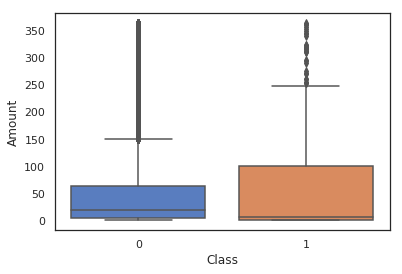

In [ ]:
sns.boxplot(x='Class', y='Amount', data=df[df.Amount < df.Amount.quantile(0.95)])

In [ ]:
df["Time"] = df["Time"].apply(lambda x : x / 3600 % 24)

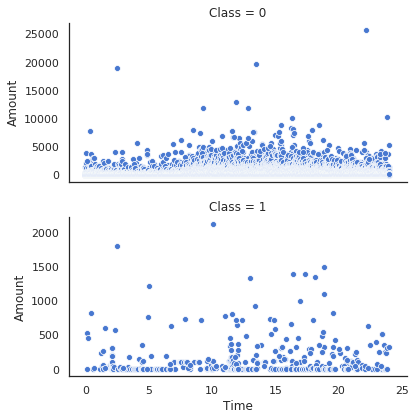

In [ ]:
g = sns.FacetGrid(df, sharey=False, height=3, aspect=2, row="Class")
g = g.map(sns.scatterplot, 'Time', "Amount");

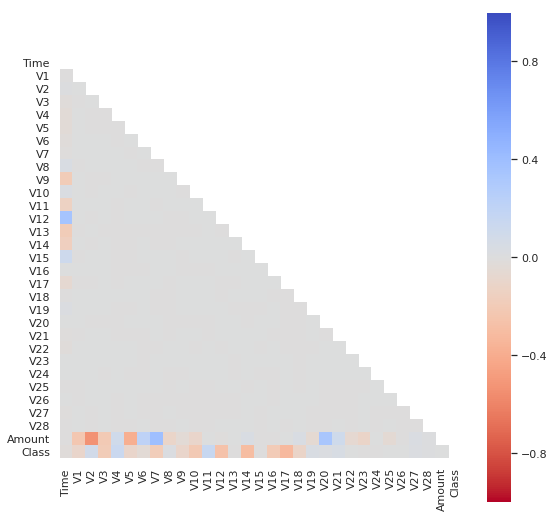

In [ ]:
def plot_corrmap(df):
    corr_all = df.corr()
    mask = np.zeros_like(corr_all, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    f, ax = plt.subplots(figsize=(9, 9))
    sns.heatmap(corr_all, mask=mask, square=True, ax=ax, vmin=-1, vmax=1, cmap="coolwarm_r")      
    plt.show()

plot_corrmap(df)

In [ ]:
fraud = df[df.Class == 1]
non_fraud = df[df.Class == 0]

In [ ]:
# Oversample training data with SMOTE
from imblearn.over_sampling import SMOTE

df_smote = non_fraud.sample(len(fraud) * 5, random_state=42).append(fraud).reset_index(drop=True)

# Synthesize elements for the minority class by computing the k-nearest neighbors
smote = SMOTE(ratio='minority')
X_smote, y_smote = smote.fit_sample(df_smote.drop('Class', axis=1).values, df_smote.Class.values)

X_smote.shape, y_smote.shape

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


((4920, 30), (4920,))

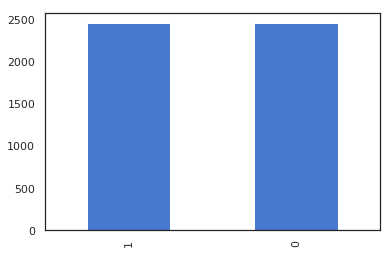

In [ ]:
pd.Series(y_smote).value_counts().plot.bar();

In [ ]:
from sklearn.model_selection import train_test_split

# Create working and test sets
X, X_test, y, y_test = train_test_split(X_smote, y_smote, test_size=.2, random_state=42)

X.shape, y.shape, X_test.shape, y_test.shape

((3936, 30), (3936,), (984, 30), (984,))

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.2, random_state=42)

# Create training and validation sets
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((3148, 30), (3148,), (788, 30), (788,))

### Compare classifiers

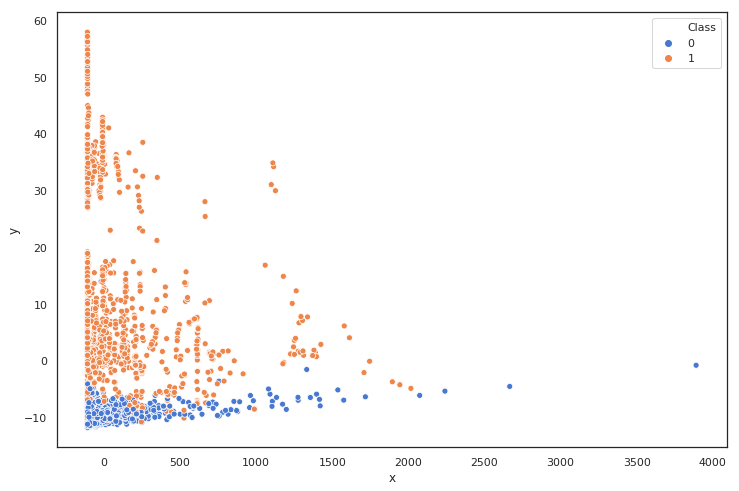

In [ ]:
from sklearn.decomposition import PCA

def plot_pca(X, y):
    pca = PCA(n_components=2)
    X_t = pca.fit_transform(X)
    
    pca_df = pd.DataFrame(X_t, columns=['x', 'y'])
    pca_df['Class'] = y

    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='x', y='y', hue='Class', data=pca_df)
    plt.show()
    
plot_pca(X, y)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

def compare_classifiers(X, y, scoring):
    X = StandardScaler().fit_transform(X)
    classifiers = {
        'LogRes': LogisticRegression(solver='liblinear'),
        "kNN": KNeighborsClassifier(3),
        "LinSVM": SVC(kernel="linear", C=0.025),
        "GaussianProcess": GaussianProcessClassifier(1.0 * RBF(1.0)),
        "DecisionTree": DecisionTreeClassifier(max_depth=5),
        "RandomForest": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
        "MLP": MLPClassifier(alpha=1, max_iter=500),
        "AdaBoost": AdaBoostClassifier(),
        "NaiveBayes": GaussianNB(),
        "QDA": QuadraticDiscriminantAnalysis()
    }

    results_df = pd.DataFrame()
    for name, model in classifiers.items():
        skf = StratifiedKFold(n_splits=3)
        cv_results = cross_validate(model, X, y, cv=skf, scoring=scoring, return_train_score=False)
        scores = cv_results['test_score']
        results_df[name] = scores
        msg = "%s: %f (%f)" % (name, scores.mean(), scores.std())
        print(msg)

    melted_df = pd.melt(results_df, id_vars=[], value_vars=results_df.columns)
    plt.figure(figsize=(16, 4))
    sns.boxplot(x='variable', y='value', data=melted_df)
    plt.show()
    
compare_classifiers(X, y, 'roc_auc')

LogRes: 0.989298 (0.000428)
kNN: 0.987497 (0.004512)
LinSVM: 0.988846 (0.000879)


In [ ]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('clf', GaussianProcessClassifier(1.0 * RBF(1.0))),
])

In [ ]:
pipe.fit(X, y)

In [ ]:
y_proba_clf = pipe.predict_proba(X_test)[:, 1]

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score

def plot_curves(y_true, y_proba):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    p, r, _ = precision_recall_curve(y_true, y_proba)
    pr_auc = average_precision_score(y_true, y_proba)
    ax1.scatter(r, p, label='AUC = %0.2f'% pr_auc, c=(p+2*r)/2, cmap=plt.cm.coolwarm_r)
    ax1.plot([0, 1], [1, 0], 'r--')
    ax1.legend()
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_title('PR Curve')
    
    # Use ROC AUC if classes are not highly imbalanced
    # The AUC gives you the probability that your classifier assigns a higher score to the positive example
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = roc_auc_score(y_true, y_proba)
    ax2.scatter(fpr, tpr, label='AUC = %0.2f'% roc_auc, c=(2*tpr+1-fpr)/2, cmap=plt.cm.coolwarm_r)
    ax2.plot([0, 1], [0, 1], 'r--')
    ax2.legend()
    ax2.set_xlabel('FPR')
    ax2.set_ylabel('TPR')
    ax2.set_title('ROC Curve')
    
    plt.show()
    
plot_curves(y_test, y_proba_clf)

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_true, y_pred), cmap='Blues', annot=True, fmt="d")
    plt.show()

plot_confusion_matrix(y_test, y_proba_clf > .5)

### Binary classifier

In [ ]:
from torch import nn

class BCModel(nn.Module):
    def __init__(self, in_size, num_units, dropout):
        super(BCModel, self).__init__()
        self.fc1 = nn.Linear(in_size, num_units)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(num_units, 1)
        
    def forward(self, x):
        x = self.dropout(torch.relu(self.fc1(x)))
        return self.fc2(x)

In [ ]:
# Requires data type Float and an extra dimension for targets
from sklearn.preprocessing import StandardScaler

X_bc = StandardScaler().fit_transform(X).astype(np.float32)
y_bc = np.expand_dims(y, 1).astype(np.float32)

X_test_bc = StandardScaler().fit_transform(X_test).astype(np.float32)
y_test_bc = np.expand_dims(y_test, 1).astype(np.float32)

In [ ]:
# Wrap a PyTorch module to make a sklearn-compatible neural network
from skorch import NeuralNet
from torch.optim import Adam

# Make recall weight more
pos_weight = torch.FloatTensor([2.])

bc_net = NeuralNet(
    module=BCModel,
    module__in_size=X_bc.shape[1],
    optimizer=Adam,
    criterion=torch.nn.BCEWithLogitsLoss,
    criterion__pos_weight=pos_weight,
    max_epochs=20,
    lr=1e-2,
    verbose=0
)

In [ ]:
# Perform a grid search
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score, precision_score, recall_score, accuracy_score

params = {
    'module__num_units': range(10, 110, 10),
    'module__dropout': [0., 0.1, 0.2, 0.3, 0.4, 0.5]
}

def sigmoid(x, derivative=False):
    sigm = 1. / (1. + np.exp(-x))
    if derivative:
        return sigm * (1. - sigm)
    return sigm

def nn_accuracy(y_valid, y_pred):
    return accuracy_score(y_valid.squeeze(), sigmoid(y_pred.squeeze()) > .5)
def nn_precision(y_valid, y_pred):
    return precision_score(y_valid.squeeze(), sigmoid(y_pred.squeeze()) > .5)
def nn_recall(y_valid, y_pred):
    return recall_score(y_valid.squeeze(), sigmoid(y_pred.squeeze()) > .5)
def nn_roc_auc(y_valid, y_pred):
    return roc_auc_score(y_valid.squeeze(), sigmoid(y_pred.squeeze()))

scoring = {
    'accuracy': make_scorer(nn_accuracy),
    'precision': make_scorer(nn_precision), 
    'recall': make_scorer(nn_recall), 
    'roc_auc': make_scorer(nn_roc_auc)
}
skf = StratifiedKFold(n_splits=3, random_state=42)
gs = GridSearchCV(bc_net, params, refit='roc_auc', iid=False, cv=skf, scoring=scoring, return_train_score=False, verbose=1)

In [ ]:
%%time
gs.fit(X_bc, y_bc)

In [ ]:
# Visualize best parameters

def plot_grid_results():
    fig = plt.figure(figsize=(11, 6))
    
    for i, param in enumerate(['mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_roc_auc']):
        ax = fig.add_subplot(221 + i)
        grid_df = pd.DataFrame(0, columns=params['module__num_units'], index=params['module__dropout'])
        for i, (p1, p2) in enumerate([d.values() for d in gs.cv_results_['params']]):
            grid_df.loc[p1, p2] = gs.cv_results_[param][i]
        sns.heatmap(grid_df, cmap='coolwarm_r', ax=ax)
        ax.set_title(param)
        
    plt.tight_layout()
    plt.show()
    
plot_grid_results()

In [ ]:
bc_net = gs.best_estimator_

In [ ]:
y_proba_bc = sigmoid(bc_net.predict(X_test_bc))

In [ ]:
plot_curves(y_test_bc, y_proba_bc)

In [ ]:
plot_confusion_matrix(y_test_bc, y_proba_bc > .5)

### Autoencoder

In [ ]:
# The autoencoder will try to learn only one class and automatically distinuish the other class

train_auto, valid_auto = train_test_split(non_fraud, test_size=0.1)
# Reserve positive samples for validation
valid_auto = valid_auto.append(fraud).reset_index(drop=True)
valid_classes = valid_auto.Class.values

train_auto = train_auto.drop('Class', axis=1).values
valid_auto = valid_auto.drop('Class', axis=1).values

train_auto.shape, valid_auto.shape

In [ ]:
# Rescale the values to be in range [0, 1] to compare with sigmoid
from sklearn.preprocessing import MinMaxScaler

train_auto = torch.FloatTensor(StandardScaler().fit_transform(train_auto))
valid_auto = torch.FloatTensor(StandardScaler().fit_transform(valid_auto))

train_auto.min(), train_auto.max()

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

train_auto_ds = TensorDataset(train_auto, train_auto)
valid_auto_ds = TensorDataset(valid_auto, valid_auto)

In [ ]:
from fastai.basic_data import DataBunch

data_auto = DataBunch.create(train_auto_ds, valid_auto_ds, bs=256)

next(iter(data_auto.train_dl))[0].shape, next(iter(data_auto.valid_dl))[0].shape

In [ ]:
# We use autoencoder to iterate through (almost) the whole dataset and learn the distribution of non-fraud
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, in_size, h_size, z_size):
        super(Autoencoder, self).__init__()
        
        self.fc1 = nn.Linear(in_size, h_size)
        self.fc2 = nn.Linear(h_size, z_size)
        self.fc3 = nn.Linear(z_size, h_size)
        self.fc4 = nn.Linear(h_size, in_size)
        
    def encode(self, x):
        x = torch.relu(self.fc1(x))
        return torch.relu(self.fc2(x))
    
    def decode(self, x):
        x = torch.relu(self.fc3(x))
        return self.fc4(x)

    def forward(self, x):
        x = self.encode(x)
        return self.decode(x)
    
# The more units the better model separates fraud from non-fraud in the latent space
autoencoder = Autoencoder(train_auto.shape[1], 100, 50)
autoencoder

In [ ]:
from fastai.train import Learner

learn_auto = Learner(data=data_auto, model=autoencoder, loss_func=nn.MSELoss())

In [ ]:
learn_auto.lr_find()
learn_auto.recorder.plot()

In [ ]:
learn_auto.fit_one_cycle(3, 1e-2)

In [ ]:
learn_auto.recorder.plot_losses()

In [ ]:
learn_auto.save('autoencoder');

In [ ]:
# Now let's try to predict fraud by using the reconstruction error
from fastai.basic_data import DatasetType

y_pred, y_true = learn_auto.get_preds(DatasetType.Valid)

In [ ]:
y_pred = y_pred.cpu().numpy()
y_true = y_true.cpu().numpy()

In [ ]:
mse = np.mean(np.power(y_pred - y_true, 2), axis=1)
mse_df = pd.DataFrame({'mse': mse, 'Class': valid_classes})
mse_df.groupby(by='Class')['mse'].describe()

In [ ]:
g = sns.FacetGrid(mse_df, sharey=False, height=3, aspect=2, row="Class")
g = g.map(sns.distplot, 'mse', kde=False, bins=50);

In [ ]:
# Find best MSE threshold after which we consider predictions as one
from sklearn.metrics import precision_score, fbeta_score

def find_best_mse_threshold(mse_df):
    mse_threshold = 0
    max_score = 0
    for v in np.linspace(mse_df.mse.min(), mse_df.mse.max(), 100):
        bound_pred = (mse_df.mse > v).astype(int).values
        if len(np.unique(bound_pred)) == len(np.unique(mse_df.Class.values)):
            score = fbeta_score(mse_df.Class.values, bound_pred, 2.)
            if score > max_score:
                max_score = score
                mse_threshold = v
    return mse_threshold

mse_threshold = find_best_mse_threshold(mse_df)
mse_threshold

In [ ]:
y_pred = (mse_df.mse > mse_threshold).astype(int).values

In [ ]:
plot_confusion_matrix(mse_df.Class.values, y_pred)

In [ ]:
# Obtain the latent representation
from fastai.callbacks import hooks

def get_z():
    z = []
    with hooks.hook_output(learn_auto.model.fc2) as hook:
        for batch, _ in learn_auto.data.valid_dl:
            m = learn_auto.model.eval()
            preds = m(batch)
            z.append(hook.stored.detach().cpu().numpy())
    return np.vstack(z)

z = get_z()

In [ ]:
fraud_idxs = np.where(np.array(valid_classes) == 1)[0]
non_fraud_idxs = np.random.choice(np.where(valid_classes == 0)[0], len(fraud_idxs))
rand_idxs = list(fraud_idxs) + list(non_fraud_idxs)

len(fraud_idxs), len(non_fraud_idxs), len(rand_idxs)

In [ ]:
# Whether the model learned to distinguish between fraud and non-fraud
plot_pca(z[rand_idxs], valid_classes[rand_idxs])

### Autoencoder + binary classifier

In [ ]:
learn_auto.load('autoencoder');

In [ ]:
X_train_abc = torch.FloatTensor(StandardScaler().fit_transform(X_train))
X_valid_abc = torch.FloatTensor(StandardScaler().fit_transform(X_valid))
X_test_abc = torch.FloatTensor(StandardScaler().fit_transform(X_test))

y_train_abc = torch.LongTensor(np.expand_dims(y_train, 1))
y_valid_abc = torch.LongTensor(np.expand_dims(y_valid, 1))
y_test_abc = torch.LongTensor(np.expand_dims(y_test, 1))

X_train_abc.shape, y_train_abc.shape, X_valid_abc.shape, y_valid_abc.shape, X_test_abc.shape, y_test_abc.shape

In [ ]:
train_abc_ds = TensorDataset(X_train_abc, y_train_abc)
valid_abc_ds = TensorDataset(X_valid_abc, y_valid_abc)
test_abc_ds = TensorDataset(X_test_abc, y_test_abc)

In [ ]:
bs = 32
data_abc = DataBunch.create(train_abc_ds, valid_abc_ds, test_abc_ds, bs=bs)

next(iter(data_abc.train_dl))[0].shape, next(iter(data_abc.valid_dl))[0].shape, next(iter(data_abc.test_dl))[0].shape

In [ ]:
# Use encoder as a frozen base and binary classifier as a head

class ABCModel(nn.Module):
    def __init__(self, autoencoder, z_size, h_size):
        super(ABCModel, self).__init__()
        self.autoencoder = autoencoder
        self.fc3 = nn.Linear(z_size, h_size)
        self.fc4 = nn.Linear(h_size, 1)

    def forward(self, x):
        x = self.autoencoder.encode(x)
        x = torch.relu(self.fc3(x))
        return torch.sigmoid(self.fc4(x))
    
model_abc = ABCModel(learn_auto.model, 50, 100)
model_abc

In [ ]:
from fastai.layers import BCEFlat

learn_abc = Learner(data=data_abc, model=model_abc, loss_func=BCEFlat())

In [ ]:
# Freeze encoder
from fastai.torch_core import requires_grad

requires_grad(learn_abc.model.autoencoder, False)
print(requires_grad(learn_abc.model.autoencoder.fc3))
print(requires_grad(learn_abc.model.autoencoder.fc4))

In [ ]:
learn_abc.lr_find()
learn_abc.recorder.plot()

In [ ]:
learn_abc.fit_one_cycle(30, 1e-2)

In [ ]:
learn_abc.recorder.plot_losses()

In [ ]:
learn_abc.save('autoencoder_bc')

In [ ]:
y_proba_abc, _ = learn_abc.get_preds(DatasetType.Test)

In [ ]:
plot_curves(y_test_abc, y_proba_abc)

In [ ]:
plot_confusion_matrix(y_test_abc, y_proba_abc > .5)

### Compare results

In [ ]:
def compare_curves(y_true, y_probas):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot([0, 1], [1, 0], 'r--')
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_title('PR Curve')
    
    ax2.plot([0, 1], [0, 1], 'r--')
    ax2.set_xlabel('FPR')
    ax2.set_ylabel('TPR')
    ax2.set_title('ROC Curve')
    
    colors = [plt.cm.tab10(i) for i in range(len(y_probas))]
    for i, (name, y_proba) in enumerate(y_probas.items()):
        p, r, _ = precision_recall_curve(y_true, y_proba)
        pr_auc = average_precision_score(y_true, y_proba)
        ax1.plot(r, p, label='%s, AUC = %0.2f'% (name, pr_auc), c=colors[i])

        fpr, tpr, _ = roc_curve(y_true, y_proba)
        roc_auc = roc_auc_score(y_true, y_proba)
        ax2.plot(fpr, tpr, label='%s, AUC = %0.2f'% (name, roc_auc), c=colors[i])
    
    ax1.legend()
    ax2.legend()
    
    plt.show()
    
compare_curves(y_test, {'clf': y_proba_clf, 'bc': y_proba_bc, 'abc': y_proba_abc})